In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_absolute_error
from copy import deepcopy
sns.set()

In [2]:
X_train = pd.read_csv('lt_train.csv')
X_test = pd.read_csv('lt_test.csv')

In [3]:
X_train.head()

,period_dt,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,id
0,2019-12-16,764.0,23285.0,NaN,0.0,0.0,2199.0,1099.5,0.0,1.0,1
1,2019-12-30,764.0,23285.0,NaN,0.0,0.0,2199.0,1099.5,0.0,1.0,3
2,2019-12-09,764.0,23285.0,NaN,0.0,0.0,2199.0,1099.5,0.0,0.0,4
3,2019-12-02,453.0,23285.0,NaN,1.0,0.0,2199.0,1319.4,0.0,1.0,5
4,2019-12-02,764.0,23285.0,NaN,1.0,0.0,2199.0,1099.5,0.0,0.0,6


In [4]:
X_train['Date'] = pd.to_datetime(X_train['period_dt'], dayfirst = True)
X_train.set_index(['Date'], inplace=True)
X_train.drop('period_dt', axis=1, inplace=True)
X_train.head()

,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,id
Date,,,,,,,,,,
2019-12-16,764.0,23285.0,NaN,0.0,0.0,2199.0,1099.5,0.0,1.0,1
2019-12-30,764.0,23285.0,NaN,0.0,0.0,2199.0,1099.5,0.0,1.0,3
2019-12-09,764.0,23285.0,NaN,0.0,0.0,2199.0,1099.5,0.0,0.0,4
2019-12-02,453.0,23285.0,NaN,1.0,0.0,2199.0,1319.4,0.0,1.0,5
2019-12-02,764.0,23285.0,NaN,1.0,0.0,2199.0,1099.5,0.0,0.0,6


In [5]:
# выделяем признаки день/месяц/год
data = X_train.reset_index().copy(deep = True)

data["monthday"] = data.Date.dt.day
data["month"] = data.Date.dt.month
data["year"] = data.Date.dt.year

# логарифмируем целевую переменную
data = data.assign(ln_demand = np.log(data['demand'] + 1))

In [6]:
data.drop('Date', axis=1, inplace=True)

In [7]:
data['demand'] = data['demand'].fillna(-10)

In [8]:
# не вошло в итоговую модель:
#создаем перенную-индикатор наличия PROMO (1 или 2)
#data['PROMO1_FLAG'] = data['PROMO1_FLAG'].fillna(0)
#data['PROMO2_FLAG'] = data['PROMO2_FLAG'].fillna(0)
#data['Promo'] = data['PROMO1_FLAG'] + data['PROMO2_FLAG']

#def scaler(x):
#    if x >=1:
#        x = 1
#    else:
#        x = 0 
#    return x 

#data['Promo'] = data['Promo'].apply(lambda x: scaler(x))

In [9]:
#data = data.drop(['PROMO1_FLAG', 'PROMO2_FLAG'], axis=1)

In [10]:
# не вошло в итоговую модель:
# создаем переменную реальной цены
#(равна обычной, если PROMO нет, и скидочной при наличии любого из двух PROMO)
# не вошло в итоговую модель, тк не улучшает качество
#data['actual_price'] = data['PRICE_REGULAR']
#data['actual_price'].loc[data['Promo'] == 1] = data['PRICE_AFTER_DISC']
#data = data.drop(['PRICE_REGULAR', 'PRICE_AFTER_DISC'], axis=1)
#data.head()

In [11]:
data['AUTORIZATION_FLAG'] = data['AUTORIZATION_FLAG'].fillna(1)
data['NUM_CONSULTANT'] = data['NUM_CONSULTANT'].fillna(0)
data['PROMO1_FLAG'] = data['PROMO1_FLAG'].fillna(0)
data['PROMO2_FLAG'] = data['PROMO2_FLAG'].fillna(0)

In [12]:
data.isnull().sum()

location_id          3001944
product_id           3001944
demand                     0
PROMO1_FLAG                0
PROMO2_FLAG                0
PRICE_REGULAR        1222255
PRICE_AFTER_DISC     1257110
NUM_CONSULTANT             0
AUTORIZATION_FLAG          0
id                         0
monthday                   0
month                      0
year                       0
ln_demand            3155253
dtype: int64

In [ ]:
# было бы с переменными Promo и actual_price
#data.isnull().sum()

location_id          3001944
product_id           3001944
demand                     0
NUM_CONSULTANT             0
AUTORIZATION_FLAG          0
id                         0
monthday                   0
month                      0
year                       0
ln_demand            3155253
Promo                      0
actual_price         1240933
dtype: int64

In [13]:
# заполним пропуски в переменных PRICE_AFTER_DISC и PRICE_REGULAR средним значением:
data['PRICE_AFTER_DISC'].fillna(data.PRICE_AFTER_DISC.mean(), inplace = True)
data['PRICE_REGULAR'].fillna(data.PRICE_REGULAR.mean(), inplace = True)

In [14]:
data = data.loc[data['location_id'].isnull() == False]
data.isnull().sum()

location_id               0
product_id                0
demand                    0
PROMO1_FLAG               0
PROMO2_FLAG               0
PRICE_REGULAR             0
PRICE_AFTER_DISC          0
NUM_CONSULTANT            0
AUTORIZATION_FLAG         0
id                        0
monthday                  0
month                     0
year                      0
ln_demand            153309
dtype: int64

In [15]:
data = data.fillna(0)

In [16]:
le = LabelEncoder()
le.fit(data['location_id'])
data['location_id'] = le.transform(data['location_id'])
le.fit(data['product_id'])
data['product_id'] = le.transform(data['product_id'])

In [17]:
# масштабирование (улучшает качество)
sc = MinMaxScaler()
sc.fit(data.iloc[:, 3:5])
data.iloc[:, 3:5] = sc.transform(data.iloc[:, 3:5])

In [ ]:
# лаговые переменные ухудшают качество предсказаний; не вошли в итоговую модель:
#def lag_features(dataframe, lags):
#    for lag in lags:
#        dataframe['demand_lag_' + str(lag)] = dataframe.groupby(["location_id", "product_id"])['demand'].transform(
#            lambda x: x.shift(lag))
#    return dataframe
#35, 87
#df = lag_features(data, [35, 87])

In [18]:
data_test = data
data = data.loc[data['demand'] > -1]

In [19]:
data_test.head()

,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,id,monthday,month,year,ln_demand
0,18,5,-10.0,0.000000,0.0,2199.0,1099.5,0.0,1.0,1,16,12,2019,0.0
1,18,5,-10.0,0.000000,0.0,2199.0,1099.5,0.0,1.0,3,30,12,2019,0.0
2,18,5,-10.0,0.000000,0.0,2199.0,1099.5,0.0,0.0,4,9,12,2019,0.0
3,5,5,-10.0,0.333333,0.0,2199.0,1319.4,0.0,1.0,5,2,12,2019,0.0
4,18,5,-10.0,0.333333,0.0,2199.0,1099.5,0.0,0.0,6,2,12,2019,0.0


In [20]:
# выделяем для обучения "новые" товары
data_new_id = []

for i in tqdm(range(1, 42)):
    data_0 = data[(data['location_id'] == i)]
    news = data_0['product_id'].tolist()
    for j in range(1, len(news)):
        if j in news:
            data_1 = data_0[(data_0['product_id'] == j)]
            if data_1.shape[0] < 10:
                data_new_id.extend(data_1['id'].tolist())
            else:
                data_1 = data_1.loc[0:10, :]
                data_new_id.extend(data_1['id'].tolist())

100%|██████████| 41/41 [00:47<00:00,  1.15s/it]


In [21]:
data = data[data['id'].isin(data_new_id)]
test_id_list = X_test['id'].tolist()

In [22]:
def days_in_month(data, num_month):
    k = list(data.loc[data['month'] == num_month]['monthday'].unique())
    k.sort()
    return(k)

In [23]:
# данные еженедельные; посмотрим дни, представленные в обучающей выборке
for i in [12,1,2,3,5,8,9]:
    print('месяц', i, ':' , days_in_month(data, i))

месяц 12 : [3, 4, 10, 11, 17, 18, 19, 24, 25, 26]
месяц 1 : [1, 2, 8, 9, 15, 16, 22, 23, 29, 30]
месяц 2 : [5, 6, 12, 13, 19, 20, 26, 27]
месяц 3 : [5, 6, 12, 13, 19, 20, 26, 27]
месяц 5 : [1, 7, 8, 14, 15, 21, 22, 28, 29]
месяц 8 : [6, 7, 13, 14, 20, 21, 27, 28]
месяц 9 : [3, 4, 10, 11, 17, 18, 24, 25]


In [24]:
data.drop('demand', axis=1, inplace=True)

In [25]:
data['ny_h'] = np.zeros(len(data))
data['may_h'] = np.zeros(len(data))
# не использовалось в лучшей модели:
#data['march8_h'] = np.zeros(len(data))
#data['feb23_h'] = np.zeros(len(data))
#data['sch_h'] = np.zeros(len(data))

# конец декабря - начало января
data['ny_h'].loc[(data['monthday'] >= 15) & (data['month'] == 12)] = 1
data['ny_h'].loc[(data['monthday'] < 9) & (data['month'] == 1)] = 1

# начало мая (+ конец марта)
data['may_h'].loc[(data['monthday'] < 9) & (data['month'] == 5)] = 1
data['may_h'].loc[(data['monthday'] > 23) & (data['month'] == 4)] = 1

# не использовалось в лучшей модели:
# перед 8 марта
#data['march8_h'].loc[(data['monthday'] < 9) & (data['month'] == 3)] = 1
#data['march8_h'].loc[(data['monthday'] > 26) & (data['month'] == 2)] = 1

# перед 23 февраля
#data['feb23_h'].loc[(data['monthday'] > 19) & (data['monthday'] < 24) & (data['month'] == 2)] = 1

# начало учебного года (+конец августа)
#data['sch_h'].loc[(data['monthday'] > 15) & (data['month'] == 8)] = 1
#data['sch_h'].loc[(data['monthday'] < 15) & (data['month'] == 9)] = 1


data_ny = data.loc[data['ny_h'] == 1]
data_may = data.loc[data['may_h'] == 1]
data_nohol = data.loc[(data['ny_h'] == 0) & (data['may_h'] == 0)]

# не использовалось в лучшей модели:
#data_march = data.loc[data['march8_h'] == 1]
#data_feb = data.loc[data['feb23_h'] == 1]
#data_sch = data.loc[data['sch_h'] == 1]

print(data_ny.shape, data_may.shape, data_nohol.shapе )

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


AttributeError: ignored

In [26]:
data_nohol = data.loc[(data['ny_h'] == 0) & (data['may_h'] == 0)]
print(data_ny.shape, data_may.shape, data_nohol.shape)

(9819, 15) (1925, 15) (38739, 15)


In [ ]:
9819+1925+38739

50483

In [ ]:
data.shape

(50483, 15)

In [27]:
def CV(X_train, y_train, number_folds, model, metrics, kwargs={}):

    k = int(np.floor(float(X_train.shape[0]) / number_folds))

    errors = np.zeros(number_folds-1)
 
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]

        index = int(np.floor(X.shape[0] * split))
       
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)
    
    return errors.mean()

In [28]:
import lightgbm as lgb

In [ ]:
!pip install catboost==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [29]:
data_test = data_test[data_test['id'].isin(test_id_list)]

In [43]:
data_test['ny_h'] = np.zeros(len(data_test))
data_test['may_h'] = np.zeros(len(data_test))
#data_test['march8_h'] = np.zeros(len(data_test))
#data_test['feb23_h'] = np.zeros(len(data_test))
#data_test['sch_h'] = np.zeros(len(data_test))

data_test['ny_h'].loc[(data_test['monthday'] >= 15) & (data_test['month'] == 12)] = 1
data_test['ny_h'].loc[(data_test['monthday'] < 9) & (data_test['month'] == 1)] = 1

data_test['may_h'].loc[(data_test['monthday'] < 9) & (data_test['month'] == 5)] = 1
data_test['may_h'].loc[(data_test['monthday'] > 23) & (data_test['month'] == 4)] = 1

#data_test['march8_h'].loc[(data_test['monthday'] < 9) & (data_test['month'] == 3)] = 1
#data_test['march8_h'].loc[(data_test['monthday'] > 26) & (data_test['month'] == 2)] = 1

#data_test['feb23_h'].loc[(data_test['monthday'] > 19) & (data_test['monthday'] < 24) & (data_test['month'] == 2)] = 1

#data_test['sch_h'].loc[(data_test['monthday'] > 15) & (data_test['month'] == 8)] = 1
#data_test['sch_h'].loc[(data_test['monthday'] < 15) & (data_test['month'] == 9)] = 1

ny_ids = list(data_test['id'].loc[data_test['ny_h'] == 1])
may_ids = list(data_test['id'].loc[data_test['may_h'] == 1])
#march_ids = list(data_test['id'].loc[data_test['march8_h'] == 1])
#feb_ids = list(data_test['id'].loc[data_test['feb23_h'] == 1])
#sch_ids = list(data_test['id'].loc[data_test['sch_h'] == 1])

nohol_ids = list(data_test['id'].loc[(data_test['ny_h'] == 0) & (data_test['may_h'] == 0)])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [34]:
y_train_ny = data_ny.ln_demand
X_train_ny = data_ny.drop(['id','ln_demand','ny_h','may_h'], axis=1)

y_train_may = data_may.ln_demand
X_train_may = data_may.drop(['id','ln_demand','ny_h','may_h'], axis=1)

y_train_nohol = data_nohol.ln_demand
X_train_nohol = data_nohol.drop(['id','ln_demand','ny_h','may_h'], axis=1)

#y_train_march = data_march.ln_demand
#X_train_march = data_march.drop(['id','ln_demand','ny_h','may_h', 'march8_h','feb23_h','sch_h'], axis=1)

#y_train_feb = data_feb.ln_demand
#X_train_feb = data_feb.drop(['id','ln_demand','ny_h','may_h', 'march8_h','feb23_h','sch_h'], axis=1)

#y_train_sch = data_sch.ln_demand
#X_train_sch = data_sch.drop(['id','ln_demand','ny_h','may_h', 'march8_h','feb23_h','sch_h'], axis=1)


In [ ]:
### LGBMRegressor
model_ny = lgb.LGBMRegressor(
                        n_estimators=200,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=35)    

model_may = lgb.LGBMRegressor(
                        n_estimators=20,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=20)

model_nohol = lgb.LGBMRegressor(
                        n_estimators=355,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40)

#model_march = lgb.LGBMRegressor(n_estimators=20,learning_rate=0.1,feature_fraction=0.7,subsample=0.4,num_leaves=20)    

#model_feb = lgb.LGBMRegressor(n_estimators=12,learning_rate=0.1,feature_fraction=0.7,subsample=0.4,num_leaves=15)

#model_sch = lgb.LGBMRegressor(n_estimators=100,learning_rate=0.1,feature_fraction=0.7,subsample=0.4,num_leaves=20)

In [30]:
kwargs={'early_stopping_rounds':10,'verbose':2}

In [ ]:
CV(X_train_ny, y_train_ny, 15, model_ny, mean_absolute_error, kwargs)
CV(X_train_may, y_train_may, 8, model_may, mean_absolute_error, kwargs)
CV(X_train_nohol, y_train_nohol, 25, model_nohol, mean_absolute_error, kwargs)

#CV(X_train_march, y_train_march, 8, model_march, mean_absolute_error, kwargs)
#CV(X_train_feb, y_train_feb, 5, model_feb, mean_absolute_error, kwargs)
#CV(X_train_sch, y_train_sch, 10, model_sch, mean_absolute_error, kwargs)


Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.108729
[4]	valid_0's l2: 0.0895676
[6]	valid_0's l2: 0.0769782
[8]	valid_0's l2: 0.0700611
[10]	valid_0's l2: 0.0654109
[12]	valid_0's l2: 0.0621562
[14]	valid_0's l2: 0.0605775
[16]	valid_0's l2: 0.0596845
[18]	valid_0's l2: 0.0594999
[20]	valid_0's l2: 0.0595009
[22]	valid_0's l2: 0.0593859
[24]	valid_0's l2: 0.0596844
[26]	valid_0's l2: 0.06008
[28]	valid_0's l2: 0.0605607
Early stopping, best iteration is:
[19]	valid_0's l2: 0.0592767

Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.101999
[4]	valid_0's l2: 0.0829489
[6]	valid_0's l2: 0.071168
[8]	valid_0's l2: 0.0633022
[10]	valid_0's l2: 0.0576875
[12]	valid_0's l2: 0.0553917
[14]	valid_0's l2: 0.0525804
[16]	valid_0's l2: 0.0502928
[18]	valid_0's l2: 0.0495852
[20]	valid_0's l2: 0.0488813
[22]	valid_0's l2: 0.047923
[24]	valid_0's l2: 0.0475304
[26]	valid_0's l2: 0.0470441
[28]	valid_0's l2: 0.0469178
[30]	valid_0

0.24720089669785597

In [ ]:
# LGBM
pred_ny = model_ny.predict(test_ny.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))
pred_may = model_may.predict(test_may.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))
pred_nohol = model_nohol.predict(test_nohol.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))

#pred_march = model_march.predict(test_march.drop(['id','demand', 'ln_demand', 'ny_h','may_h', 'march8_h','feb23_h','sch_h'], axis=1))
#pred_feb = model_feb.predict(test_feb.drop(['id','demand', 'ln_demand', 'ny_h','may_h', 'march8_h','feb23_h','sch_h'], axis=1))
#pred_sch = model_sch.predict(test_sch.drop(['id','demand', 'ln_demand', 'ny_h','may_h', 'march8_h','feb23_h','sch_h'], axis=1))

In [ ]:
ny = pd.DataFrame({'id': ny_ids, 'demand': pred_ny})
may = pd.DataFrame({'id': may_ids, 'demand': pred_may})
#march = pd.DataFrame({'id': march_ids, 'demand': pred_march})
#feb = pd.DataFrame({'id': feb_ids, 'demand': pred_feb})
#sch = pd.DataFrame({'id': sch_ids, 'demand': pred_sch})
nohol = pd.DataFrame({'id': nohol_ids, 'demand': pred_nohol})

pred = pd.concat([ny,may,nohol])

In [ ]:
final_pred = pd.DataFrame({'id': test_id_list})
final_pred = final_pred.merge(pred, on = 'id')
final_pred['demand'] = np.exp(final_pred['demand']) - 1
final_pred.head()

In [ ]:
final_pred.to_csv('holidays12.csv', index=False) 

# Catboost

In [32]:
!pip install catboost==1.0.3
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.3 MB 1.3 MB/s 


посмотрим на MAE модели Catboost при тренировке и тестировании c разными гиперпараметрами: количество деревьев и глубина одного дерева. 

тренировочная и тестовая выборки были получены путем деления исходной обучающей выборки в пропорции 75:25.

In [35]:
# для nohol
test_size = 0.25

test_index = int(len(X_train_nohol) * (1 - test_size))

Xtrain_cb_nohol = X_train_nohol.iloc[:test_index]
ytrain_cb_nohol = y_train_nohol.iloc[:test_index]
Xtest_cb_nohol = X_train_nohol.iloc[test_index:]
ytest_cb_nohol = y_train_nohol.iloc[test_index:]

pool_train_nohol = Pool(Xtrain_cb_nohol, ytrain_cb_nohol)

pool_test_nohol = Pool(Xtest_cb_nohol)

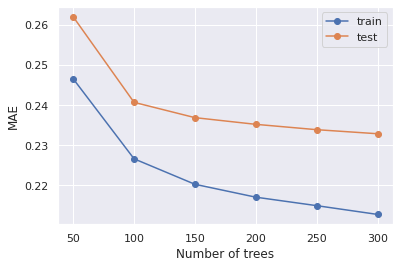

In [ ]:
n_trees = [50, 100, 150, 200, 250, 300]
quals_train = []
quals_test = []
for n in n_trees:
  cb = CatBoostRegressor(n_estimators=n,
                       loss_function='MAE',
                       depth=7,
                       random_state=1,
                       verbose=0)
  cb.fit(pool_train_nohol)
  q_train = mean_absolute_error(ytrain_cb_nohol, cb.predict(pool_train_nohol))
  q_test = mean_absolute_error(ytest_cb_nohol, cb.predict(pool_test_nohol))
  quals_train.append(q_train)
  quals_test.append(q_test)


plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('MAE')
plt.legend()
plt.show()

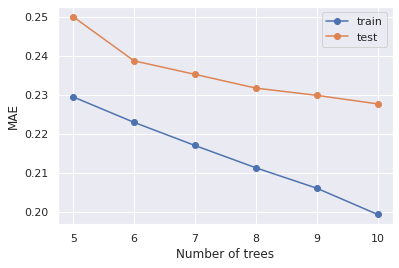

In [ ]:
depth = [5,6,7, 8,9,10]
quals_train = []
quals_test = []
for n in depth:
  cb = CatBoostRegressor(n_estimators=200,
                       loss_function='MAE',
                       depth=n,
                       random_state=1,
                       verbose=0)
  cb.fit(pool_train_nohol)
  q_train = mean_absolute_error(ytrain_cb_nohol, cb.predict(pool_train_nohol))
  q_test = mean_absolute_error(ytest_cb_nohol, cb.predict(pool_test_nohol))
  quals_train.append(q_train)
  quals_test.append(q_test)


plt.plot(depth, quals_train, marker='o', label='train')
plt.plot(depth, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [36]:
# для ny
test_size = 0.25

test_index = int(len(X_train_ny) * (1 - test_size))

Xtrain_cb_ny = X_train_ny.iloc[:test_index]
ytrain_cb_ny = y_train_ny.iloc[:test_index]
Xtest_cb_ny = X_train_ny.iloc[test_index:]
ytest_cb_ny = y_train_ny.iloc[test_index:]

pool_train_ny = Pool(Xtrain_cb_ny, ytrain_cb_ny)

pool_test_ny = Pool(Xtest_cb_ny)

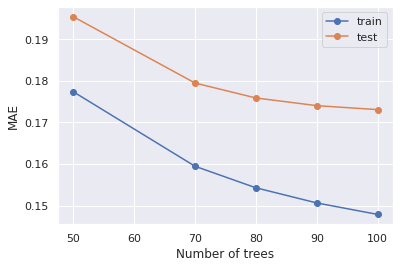

In [37]:
n_trees = [50, 70, 80, 90, 100]
quals_train = []
quals_test = []
for n in n_trees:
  cb = CatBoostRegressor(n_estimators=n,
                       loss_function='MAE',
                       depth=6,
                       random_state=1,
                       verbose=0)
  cb.fit(pool_train_ny)
  q_train = mean_absolute_error(ytrain_cb_ny, cb.predict(pool_train_ny))
  q_test = mean_absolute_error(ytest_cb_ny, cb.predict(pool_test_ny))
  quals_train.append(q_train)
  quals_test.append(q_test)


plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('MAE')
plt.legend()
plt.show()

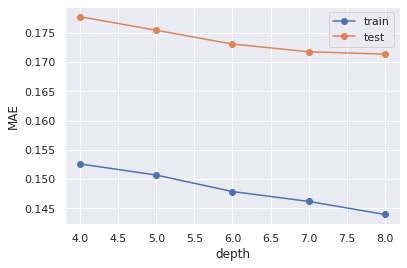

In [38]:
depth = [4,5,6,7,8]
quals_train = []
quals_test = []
for n in depth:
  cb = CatBoostRegressor(n_estimators=100,
                       loss_function='MAE',
                       depth=n,
                       random_state=1,
                       verbose=0)
  cb.fit(pool_train_ny)
  q_train = mean_absolute_error(ytrain_cb_ny, cb.predict(pool_train_ny))
  q_test = mean_absolute_error(ytest_cb_ny, cb.predict(pool_test_ny))
  quals_train.append(q_train)
  quals_test.append(q_test)


plt.plot(depth, quals_train, marker='o', label='train')
plt.plot(depth, quals_test, marker='o', label='test')
plt.xlabel('depth')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# для may
test_size = 0.25

test_index = int(len(X_train_may) * (1 - test_size))

Xtrain_cb_may = X_train_may.iloc[:test_index]
ytrain_cb_may = y_train_may.iloc[:test_index]
Xtest_cb_may = X_train_may.iloc[test_index:]
ytest_cb_may = y_train_may.iloc[test_index:]

pool_train_may = Pool(Xtrain_cb_may, ytrain_cb_may)

pool_test_may = Pool(Xtest_cb_may)

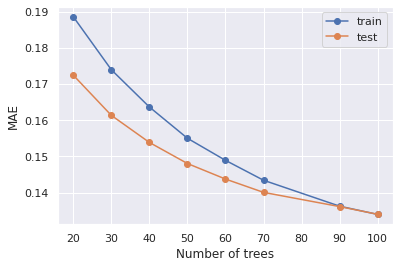

In [ ]:
n_trees = [20, 30, 40, 50,60, 70, 90, 100]
quals_train = []
quals_test = []
for n in n_trees:
  cb = CatBoostRegressor(n_estimators=n,
                       loss_function='MAE',
                       depth=6,
                       random_state=1,
                       verbose=0)
  cb.fit(pool_train_may)
  q_train = mean_absolute_error(ytrain_cb_may, cb.predict(pool_train_may))
  q_test = mean_absolute_error(ytest_cb_may, cb.predict(pool_test_may))
  quals_train.append(q_train)
  quals_test.append(q_test)


plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('MAE')
plt.legend()
plt.show()

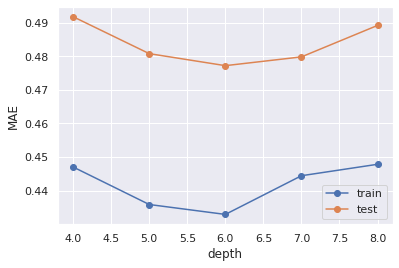

In [ ]:
depth = [4,5,6,7,8]
quals_train = []
quals_test = []
for n in depth:
  cb = CatBoostRegressor(n_estimators=70,
                       loss_function='MAE',
                       depth=n,
                       random_state=1,
                       verbose=0)
  cb.fit(pool_train_ny)
  q_train = mean_absolute_error(ytrain_cb_may, cb.predict(pool_train_may))
  q_test = mean_absolute_error(ytest_cb_may, cb.predict(pool_test_may))
  quals_train.append(q_train)
  quals_test.append(q_test)


plt.plot(depth, quals_train, marker='o', label='train')
plt.plot(depth, quals_test, marker='o', label='test')
plt.xlabel('depth')
plt.ylabel('MAE')
plt.legend()
plt.show()

наилучшие гиперапараметры: 
- для данных без праздничных дней: количество деревьев = 200, глубина = 9
- для майских праздников: количество деревьев = 70, глубина = 6
- для новогодних праздников: количество деревьев = 100, глубина = 7

In [40]:
### CatboostRegressor

model_Cny = CatBoostRegressor(n_estimators=100,
                       loss_function='MAE',
                       depth=7,
                       random_state=1,
                       verbose=0)    

model_Cmay = CatBoostRegressor(n_estimators=70,
                       loss_function='MAE',
                       depth=6,
                       random_state=1,
                       verbose=0)

model_Cnohol = CatBoostRegressor(n_estimators=200,
                       loss_function='MAE',
                       depth=9,
                       random_state=1,
                       verbose=0)


In [41]:
CV(X_train_ny, y_train_ny, 15, model_Cny, mean_absolute_error, kwargs)
CV(X_train_may, y_train_may, 8, model_Cmay, mean_absolute_error, kwargs)
CV(X_train_nohol, y_train_nohol, 25, model_Cnohol, mean_absolute_error, kwargs)


0:	learn: 0.2574000	test: 0.3256333	best: 0.3256333 (0)	total: 1.26ms	remaining: 125ms
2:	learn: 0.2460124	test: 0.3102169	best: 0.3102169 (2)	total: 2.68ms	remaining: 86.7ms
4:	learn: 0.2353060	test: 0.2958654	best: 0.2958654 (4)	total: 3.4ms	remaining: 64.6ms
6:	learn: 0.2250773	test: 0.2826654	best: 0.2826654 (6)	total: 5.27ms	remaining: 70ms
8:	learn: 0.2155439	test: 0.2709678	best: 0.2709678 (8)	total: 7.55ms	remaining: 76.4ms
10:	learn: 0.2069024	test: 0.2600454	best: 0.2600454 (10)	total: 9.36ms	remaining: 75.7ms
12:	learn: 0.1988760	test: 0.2499720	best: 0.2499720 (12)	total: 10.9ms	remaining: 73.2ms
14:	learn: 0.1914665	test: 0.2430144	best: 0.2430144 (14)	total: 12.6ms	remaining: 71.5ms
16:	learn: 0.1844464	test: 0.2348910	best: 0.2348910 (16)	total: 15ms	remaining: 73.2ms
18:	learn: 0.1781798	test: 0.2277748	best: 0.2277748 (18)	total: 17.3ms	remaining: 73.9ms
20:	learn: 0.1725114	test: 0.2214835	best: 0.2214835 (20)	total: 19.6ms	remaining: 73.7ms
22:	learn: 0.1674066	test

0.23755012951840918

In [44]:
test_ny = data_test.loc[data_test['ny_h'] == 1]
test_may = data_test.loc[data_test['may_h'] == 1]
test_nohol = data_test.loc[(data_test['ny_h'] == 0) & (data_test['may_h'] == 0)]

In [45]:
pred_ny = model_Cny.predict(test_ny.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))
pred_may = model_Cmay.predict(test_may.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))
pred_nohol = model_Cnohol.predict(test_nohol.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))

In [46]:
ny = pd.DataFrame({'id': ny_ids, 'demand': pred_ny})
may = pd.DataFrame({'id': may_ids, 'demand': pred_may})
nohol = pd.DataFrame({'id': nohol_ids, 'demand': pred_nohol})

pred = pd.concat([ny,may,nohol])

In [47]:
final_pred = pd.DataFrame({'id': test_id_list})
final_pred = final_pred.merge(pred, on = 'id')
final_pred['demand'] = np.exp(final_pred['demand']) - 1
final_pred.head()

,id,demand
0,601,0.616686
1,697,0.613796
2,831,0.668921
3,875,0.862921
4,975,0.694257


In [48]:
final_pred.to_csv('holidaysC4.csv', index=False) 

# xgboost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# подбор гиперпараметров XGBRegressor для непраздничных дней
xgb1 = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07, 0.1],
              'max_depth': [5, 6, 7, 8],
              'n_estimators': [150, 200, 250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_nohol,
         y_train_nohol)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[19:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.395509004146001
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear'}


In [ ]:
# подбор гиперпараметров XGBRegressor для майских праздников
xgb2 = XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05,0.07, 0.1], 
              'max_depth': [4,5, 6, 7],
              'n_estimators': [35, 40, 45, 50]}

xgb_grid = GridSearchCV(xgb2,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_may,
         y_train_may)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[19:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.4480090394974641
{'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 40, 'nthread': 4, 'objective': 'reg:linear'}


In [ ]:
# подбор гиперпараметров XGBRegressor для новогодних праздников
xgb3 = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.01, 0.05, 0.1], 
              'max_depth': [3,4,5, 6],
              'n_estimators': [80,90,100,110]}

xgb_grid = GridSearchCV(xgb3,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_ny,
         y_train_ny)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[19:51:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5450232209557941
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:linear'}


In [ ]:
# инициализация моделей с наилучшими гиперпараметрами:
xgb_nohol = XGBRegressor(objective='reg:linear',
              learning_rate= 0.05, 
              max_depth= 6,
              n_estimators=250)

xgb_may = XGBRegressor(objective='reg:linear',
              learning_rate= 0.05, 
              max_depth= 5,
              n_estimators=40)

xgb_ny = XGBRegressor(objective='reg:linear',
              learning_rate= 0.05, 
              max_depth= 5,
              n_estimators=100)

In [ ]:
CV(X_train_ny, y_train_ny, 15, xgb_ny, mean_absolute_error, kwargs)
CV(X_train_may, y_train_may, 8, xgb_may, mean_absolute_error, kwargs)
CV(X_train_nohol, y_train_nohol, 25, xgb_nohol, mean_absolute_error, kwargs)


[20:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.38383
Will train until validation_0-rmse hasn't improved in 10 rounds.
[2]	validation_0-rmse:0.36122
[4]	validation_0-rmse:0.341752
[6]	validation_0-rmse:0.325242
[8]	validation_0-rmse:0.311091
[10]	validation_0-rmse:0.299363
[12]	validation_0-rmse:0.288902
[14]	validation_0-rmse:0.281252
[16]	validation_0-rmse:0.274688
[18]	validation_0-rmse:0.268751
[20]	validation_0-rmse:0.263857
[22]	validation_0-rmse:0.260888
[24]	validation_0-rmse:0.257761
[26]	validation_0-rmse:0.255361
[28]	validation_0-rmse:0.253445
[30]	validation_0-rmse:0.251981
[32]	validation_0-rmse:0.250861
[34]	validation_0-rmse:0.250045
[36]	validation_0-rmse:0.249391
[38]	validation_0-rmse:0.249046
[40]	validation_0-rmse:0.248853
[42]	validation_0-rmse:0.24811
[44]	validation_0-rmse:0.247703
[46]	validation_0-rmse:0.247431
[48]	validation_0-rmse:0.24734
[50]	validation_

0.25303080087528246

In [ ]:
test_ny = data_test.loc[data_test['ny_h'] == 1]
test_may = data_test.loc[data_test['may_h'] == 1]
test_nohol = data_test.loc[(data_test['ny_h'] == 0) & (data_test['may_h'] == 0)]

pred_ny = xgb_ny.predict(test_ny.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))
pred_may = xgb_may.predict(test_may.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))
pred_nohol = xgb_nohol.predict(test_nohol.drop(['id','demand', 'ln_demand', 'ny_h','may_h'], axis=1))

In [ ]:
ny = pd.DataFrame({'id': ny_ids, 'demand': pred_ny})
may = pd.DataFrame({'id': may_ids, 'demand': pred_may})
nohol = pd.DataFrame({'id': nohol_ids, 'demand': pred_nohol})

pred = pd.concat([ny,may,nohol])

final_pred = pd.DataFrame({'id': test_id_list})
final_pred = final_pred.merge(pred, on = 'id')
final_pred['demand'] = np.exp(final_pred['demand']) - 1
final_pred.head()

,id,demand
0,601,0.439176
1,697,0.521169
2,831,0.550296
3,875,1.317106
4,975,0.584458


In [ ]:
final_pred.to_csv('holidays333.csv', index=False)